# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [2]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [4]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(3947, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  3947 non-null   int64  
 1   year                 3947 non-null   int64  
 2   productGrouping      3947 non-null   object 
 3   totalSpent           3947 non-null   float64
 4   recentDate           3947 non-null   object 
 5   attendancePercent    3947 non-null   float64
 6   renewedBeforeDays    3947 non-null   int64  
 7   source_tenure        3947 non-null   int64  
 8   tenure               3947 non-null   int64  
 9   distToVenue          3805 non-null   float64
 10  recency              3947 non-null   int64  
 11  missed_games_1       3947 non-null   int64  
 12  missed_games_2       3947 non-null   int64  
 13  missed_games_over_2  3947 non-null   int64  
 14  isNextYear_Buyer     3947 non-null   int64  
dtypes: float64(3), int64(10), object(2)
me

### We should specify the features used in our model:

In [6]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2412, 15)
Unseen Data For Predictions: (426, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [8]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [9]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm","lr","xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6859,0.6333,0.0159,0.2851,0.0293,-0.0023,-0.0066,0.0720
lightgbm,Light Gradient Boosting Machine,0.6678,0.6599,0.2940,0.4354,0.3498,0.1391,0.1439,0.7110
xgboost,Extreme Gradient Boosting,0.6600,0.6500,0.3148,0.4255,0.3610,0.1371,0.1401,3.6920


In [10]:
lightgbm_model = create_model('lightgbm')
lr_model = create_model('lr')
xgboost_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6683,0.6502,0.3226,0.4348,0.3704,0.1519,0.1550
1,0.6683,0.6017,0.2540,0.4324,0.3200,0.1198,0.1273
2,0.6634,0.6711,0.3492,0.4400,0.3894,0.1613,0.1633
3,0.6683,0.6994,0.3492,0.4490,0.3929,0.1695,0.1721
4,0.6488,0.6363,0.2698,0.3953,0.3208,0.0951,0.0983
5,0.6537,0.6450,0.2857,0.4091,0.3364,0.1120,0.1153
6,0.6439,0.6288,0.2698,0.3864,0.3178,0.0870,0.0896
7,0.6683,0.6094,0.3492,0.4490,0.3929,0.1695,0.1721
8,0.6488,0.6602,0.3016,0.4043,0.3455,0.1123,0.1146
9,0.6683,0.6977,0.3968,0.4545,0.4237,0.1924,0.1932


### Let's load in our 2021 season data and get retention scores using the model:

In [11]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(1109, 15)

In [12]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)
lr_predictions = predict_model(lr_model, data=df_inference, raw_score=True)
xgboost_predictions = predict_model(xgboost_model, data=df_inference, raw_score=True)

In [13]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")
print(f"log reg:\n {lr_predictions.Label.value_counts()}")
print(f"xgboost:\n {xgboost_predictions.Label.value_counts()}")

lightgbm:
 0    926
1    183
Name: Label, dtype: int64
log reg:
 0    1109
Name: Label, dtype: int64
xgboost:
 0    924
1    185
Name: Label, dtype: int64


In [14]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"lr:\n {lr_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"xgboost:\n {xgboost_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    621
(0.25, 0.5]       305
(0.5, 0.75]       130
(0.75, 1.0]        53
Name: Score_1, dtype: int64
lr:
 (-0.001, 0.25]    755
(0.25, 0.5]       354
(0.5, 0.75]         0
(0.75, 1.0]         0
Name: Score_1, dtype: int64
xgboost:
 (-0.001, 0.25]    743
(0.25, 0.5]       181
(0.5, 0.75]       113
(0.75, 1.0]        72
Name: Score_1, dtype: int64


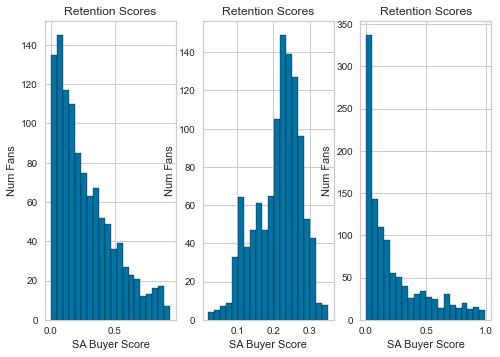

In [15]:
model_predictions = [lightgbm_predictions, lr_predictions, xgboost_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

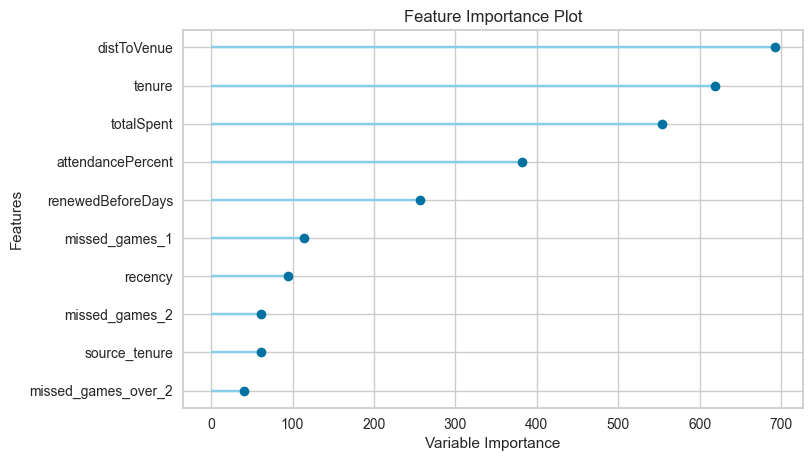

In [16]:
plot_model(lightgbm_model, plot='feature')

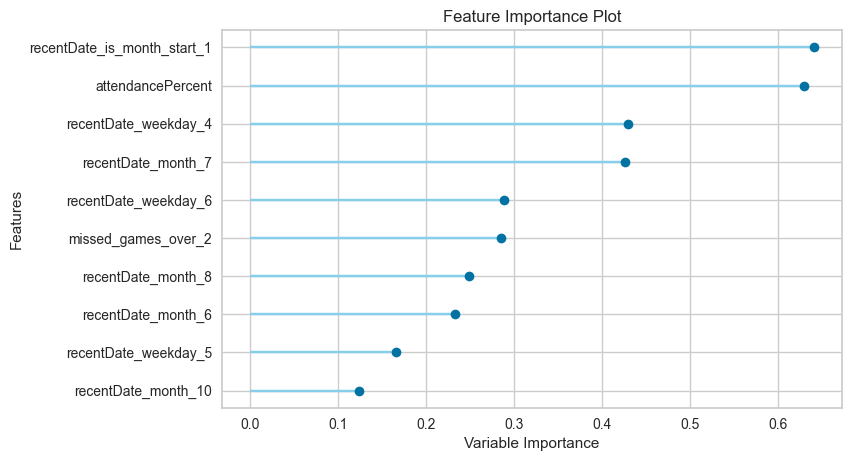

In [17]:
plot_model(lr_model, plot='feature')

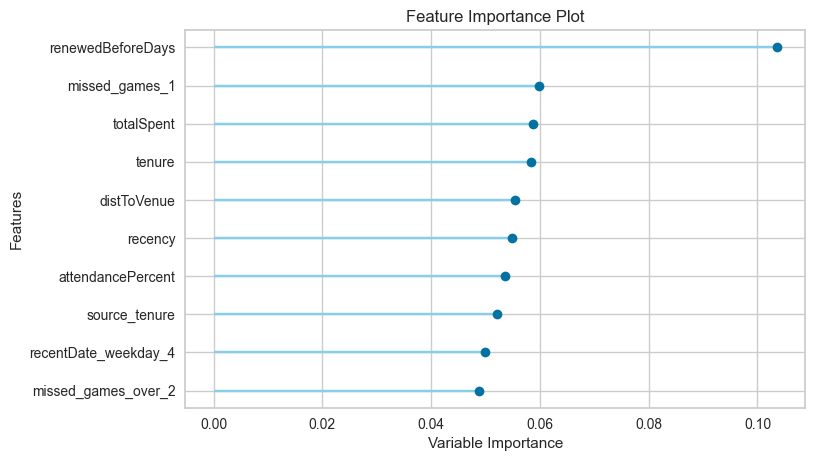

In [18]:
plot_model(xgboost_model, plot='feature')

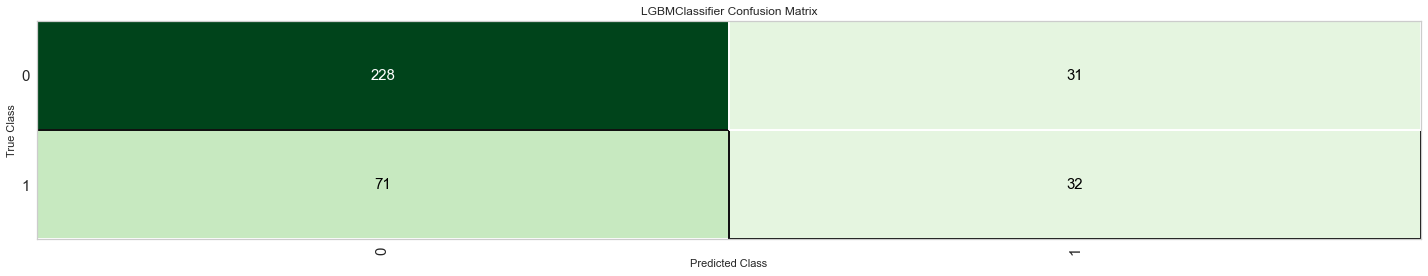

In [19]:
plot_model(lightgbm_model, plot='confusion_matrix')

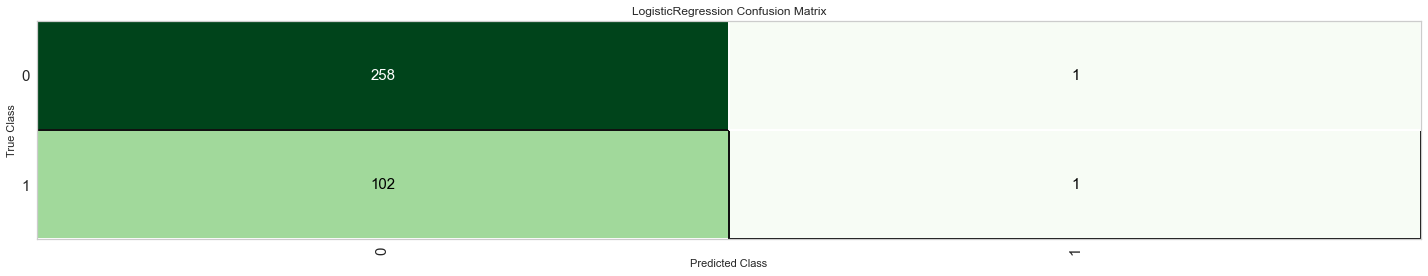

In [20]:
plot_model(lr_model, plot='confusion_matrix')

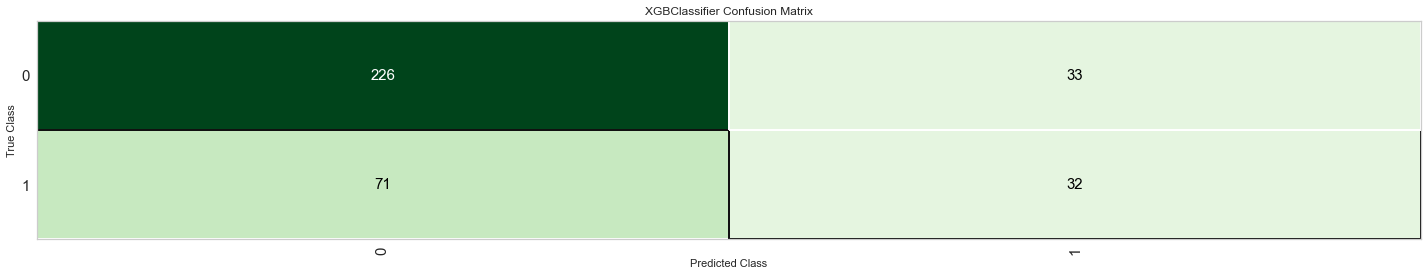

In [21]:
plot_model(xgboost_model, plot='confusion_matrix')

In [22]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,42,2022,Flex Plan,312.00,2022-06-25,0.38,10,730,150,38.20,1,1,0,0,0,0,0.9737,0.0263
4,238,2022,Half Season,466.00,2022-05-14,0.60,6,365,217,14.62,2,0,1,0,0,0,0.9303,0.0697
6,313,2022,Full Season,1267.50,2022-03-12,1.00,103,365,103,3764.39,0,0,0,0,0,0,0.9555,0.0445
8,322,2022,Full Season,875.50,2022-06-25,0.60,159,1095,1054,29.38,1,2,1,0,0,0,0.9330,0.0670
15,454,2022,Full Season,700.40,2022-06-25,0.30,162,1095,1087,23.14,1,1,0,1,0,0,0.9254,0.0746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,235740,2022,Full Season,405.00,2022-04-24,1.00,0,365,59,50.84,0,0,0,0,0,0,0.9984,0.0016
3940,238726,2022,Full Season,1912.72,2022-06-25,0.58,1,0,135,8.55,1,1,0,0,0,0,0.8750,0.1250
3942,241919,2022,Full Season,3187.32,2022-06-25,0.75,5,0,145,56.49,1,1,0,0,0,0,0.8613,0.1387
3944,244313,2022,Full Season,1575.90,2022-05-14,0.30,162,1095,1094,38.86,4,0,0,2,0,0,0.7460,0.2540


In [24]:
from datetime import datetime
current_date = datetime.today().strftime('%Y-%m-%d')
lightgbm_predictions.to_csv(f"Results/InterMaimi_Scores_{current_date}.csv", index=False)

## Observations
Here you can document some ideas on the results from above